PSNR host vs watermarked: 34.472073254288894 dB
BER (clean): 0.0859375


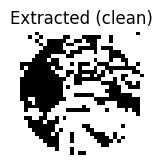

BER (jpeg q75): 0.0712890625


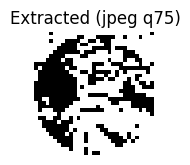

BER (small cutout): 0.095703125


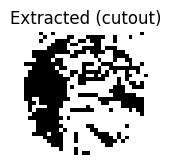

In [58]:
import math
import cv2
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# =========================
# Adjustable hyperparameters
# =========================
DWT_LEVELS        = 2
DCT_BLOCK_SIZE    = 8
QIM_STEP          = 100.0
WAVELET_NAME      = 'haar'
WAVELET_MODE      = 'symmetric'
WATERMARK_SIZE    = 32

# =========================
# Small utilities
# =========================
def show_watermark(wm, title="Watermark", scale=4, threshold=None, save_path=None):
    """Display a single watermark (binarize if needed) with crisp pixels."""
    a = np.asarray(wm)
    thr = (0.5 if a.max() <= 1.0 else 127) if threshold is None else threshold
    a_bin = (a > thr).astype(np.uint8)
    a_disp = np.kron(a_bin, np.ones((max(1, int(scale)), max(1, int(scale))), dtype=np.uint8))
    plt.figure(figsize=(a_disp.shape[1]/80, a_disp.shape[0]/80))
    plt.imshow(a_disp, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
    plt.title(title); plt.axis("off")
    if save_path: plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def psnr(img_a_u8, img_b_u8):
    a = img_a_u8.astype(np.float64)
    b = img_b_u8.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    return 100.0 if mse <= 1e-12 else 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits_u8, pred_bits_u8):
    true_bits_u8 = np.asarray(true_bits_u8).astype(np.uint8).ravel()
    pred_bits_u8 = np.asarray(pred_bits_u8).astype(np.uint8).ravel()
    assert true_bits_u8.size == pred_bits_u8.size, "Mismatch in bit lengths."
    return np.count_nonzero(true_bits_u8 ^ pred_bits_u8) / true_bits_u8.size

def to_ycbcr_arrays(pil_rgb):
    """Return Y (float64), Cb (uint8), Cr (uint8)."""
    ycbcr = pil_rgb.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr

def from_ycbcr_arrays(Y_float, Cb_u8, Cr_u8):
    """Merge Y, Cb, Cr back to RGB (uint8)."""
    Y_u8 = np.rint(np.clip(Y_float, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y_u8),
                                  Image.fromarray(Cb_u8),
                                  Image.fromarray(Cr_u8)))
    return ycbcr.convert("RGB")

def prepare_watermark_bits(path, size=WATERMARK_SIZE):
    """Load any image → grayscale → Otsu → resize to size×size, return 0/1 bits."""
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.uint8)
    _, thr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = Image.fromarray(thr).resize((size, size), Image.NEAREST)
    bits = (np.array(thr, dtype=np.uint8) > 127).astype(np.uint8)
    return bits

# =========================
# DWT helpers (multi-level)
# =========================
def dwt2_levels(img_2d, levels=DWT_LEVELS):
    return pywt.wavedec2(img_2d, wavelet=WAVELET_NAME, level=levels, mode=WAVELET_MODE)

def idwt2_levels(coeffs):
    return pywt.waverec2(coeffs, wavelet=WAVELET_NAME, mode=WAVELET_MODE)

def get_detail_bands_all_levels(coeffs):
    """
    Return a list of (level_idx, band_tag, band_array_ref) for detail bands only.
    band_tag ∈ {'H','V'} (no diagonal band).
    """
    out = []
    levels = len(coeffs) - 1
    for l in range(levels, 0, -1):
        cH, cV, cD = coeffs[levels - l + 1]
        out.append((l, 'H', cH))
        out.append((l, 'V', cV))
    return out

def set_detail_band(coeffs, level_idx, band_tag, new_arr):
    """Write back a specific detail band at a given level."""
    levels = len(coeffs) - 1
    i = levels - level_idx + 1
    cH, cV, cD = coeffs[i]
    if band_tag == 'H':
        coeffs[i] = (new_arr, cV, cD)
    elif band_tag == 'V':
        coeffs[i] = (cH, new_arr, cD)

# =========================
# DCT (8×8 blockwise) helpers
# =========================
def dct_blocks_8x8(arr2d):
    """Blockwise 8×8 DCT with edge padding to multiples of 8."""
    H, W = arr2d.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(arr2d, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct_blocks_8x8(D, H, W):
    """Inverse blockwise 8×8 DCT; crop back to original size."""
    H8, W8 = D.shape
    out = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            out[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return out[:H, :W]

# =========================
# QIM primitives (scalar) on a single value
# =========================
def qim_embed_scalar(x, bit, step):
    """Quantize x into the center of the bit-labeled interval with step Δ=step."""
    q = np.floor(x / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_llr_scalar(x, step):
    """Soft-decision score: >0 means closer to bit=1; <0 closer to bit=0."""
    x /= step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# =========================
# SVD-on-block helpers (inside an 8×8 DCT block)
# =========================
def svd_qim_embed_in_block(D8, bit, step, svd_idx=0):
    """Embed bit into the singular value of an 8x8 DCT block using QIM."""
    U, S, Vt = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    S[k] = qim_embed_scalar(S[k], int(bit), step)
    D8[:] = (U * S) @ Vt  # U @ diag(S) @ Vt

def svd_qim_llr_from_block(D8, step, svd_idx=0):
    """Extract the soft-decision score for a given bit."""
    _, S, _ = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    return qim_llr_scalar(S[k], step)

# =========================
# Embedding (Y channel only) — NO TILING, NO RANDOM
# =========================
def embed_watermark_y(y_luma, wm_bits_2d):
    """
    Embed size×size binary watermark into Y using deterministic round-robin mapping.
    - Never touches LL subbands.
    - No randomness: block k carries bit (k % n_bits).
    """
    H0, W0 = y_luma.shape
    if not (512 <= H0 <= 1080 and 512 <= W0 <= 1080):
        raise ValueError("Host image must be within 512–1080 px on BOTH height and width.")

    # Pad so DWT levels and 8×8 DCT align cleanly
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    # DWT
    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    wm_bits = wm_bits_2d.astype(np.uint8).ravel()
    n_bits  = wm_bits.size

    for lvl, tag, band in detail_bands:
        # DCT over the entire band (single region)
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Deterministic round-robin mapping: block k → bit (k % n_bits)
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        # Embed per-block
        for k in range(n_blocks):
            bit_index = int(assign[k])
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            svd_qim_embed_in_block(
                D[i:i+8, j:j+8],
                int(wm_bits[bit_index]),
                QIM_STEP
            )

        # Write back the modified band
        band[:] = idct_blocks_8x8(D, Hb, Wb)
        set_detail_band(coeffs, lvl, tag, band)

    # Inverse DWT and crop back to original size
    y_wm_pad = idwt2_levels(coeffs)
    return y_wm_pad[:H0, :W0]

# =========================
# Extraction (blind) — NO TILING, NO RANDOM
# =========================
def extract_watermark_y(y_luma, wm_size=WATERMARK_SIZE):
    """
    Recreate the same deterministic round-robin mapping and do soft voting.
    """
    H0, W0 = y_luma.shape
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    n_bits = wm_size * wm_size
    soft_sum = np.zeros(n_bits, dtype=np.float64)

    for lvl, tag, band in detail_bands:
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Same round-robin mapping
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        for k in range(n_blocks):
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            llr = svd_qim_llr_from_block(
                D[i:i+8, j:j+8],
                QIM_STEP
            )
            soft_sum[int(assign[k])] += llr

    bits = (soft_sum >= 0).astype(np.uint8)
    return bits.reshape(wm_size, wm_size)

# =========================
# High-level convenience I/O
# =========================
def embed_watermark(host_path, wm_path, out_path="watermarked.png"):
    """Embed watermark image into host image file and save the watermarked RGB."""
    rgb = Image.open(host_path).convert("RGB")
    Y, Cb, Cr = to_ycbcr_arrays(rgb)
    wm_bits = prepare_watermark_bits(wm_path, WATERMARK_SIZE)
    Y_wm = embed_watermark_y(Y, wm_bits)
    out_rgb = from_ycbcr_arrays(Y_wm, Cb, Cr)
    out_rgb.save(out_path)
    return np.array(rgb, dtype=np.uint8), np.array(out_rgb, dtype=np.uint8), wm_bits

def extract_watermark(image_path, wm_size=WATERMARK_SIZE):
    """Extract watermark bits (wm_size×wm_size) from a watermarked/attacked image file."""
    rgb = Image.open(image_path).convert("RGB")
    Y, _, _ = to_ycbcr_arrays(rgb)
    wm_bits = extract_watermark_y(Y, wm_size)
    return wm_bits

# =========================
# (Optional) simple attack helpers for testing
# =========================
def attack_jpeg(in_path, out_path, quality=80):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_resize(in_path, out_path, scale=0.9):
    img = Image.open(in_path).convert("RGB")
    w, h = img.size
    img2 = img.resize((max(1, int(w*scale)), max(1, int(h*scale))), Image.LANCZOS)
    img3 = img2.resize((w, h), Image.LANCZOS)
    img3.save(out_path)

def attack_blur(in_path, out_path, k=3):
    arr = np.array(Image.open(in_path).convert("RGB"), dtype=np.uint8)
    k = k if k % 2 == 1 else k+1
    arrb = cv2.GaussianBlur(arr, (k, k), 0)
    Image.fromarray(arrb).save(out_path)

def attack_small_cutout(in_path, out_path,
                        area_ratio=0.008,     # ≈0.8% of full image area per patch
                        num_patches=2,
                        shape="rect",         # "rect" | "circle"
                        fill="noise",         # "noise" | "black" | "avg" | "blur" | "inpaint"
                        blur_kernel=11,
                        seed=None):
    """Tiny cutouts while keeping size; seed only for reproducibility of the ATTACK (not watermark)."""
    img = Image.open(in_path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    if fill == "blur":
        k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
        blurred = cv2.GaussianBlur(arr, (k, k), 0)

    def rect_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8); m[y0:y0+h, x0:x0+w] = 255; return m

    def circle_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2; r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]; m[(yy - cy)**2 + (xx - cx)**2 <= r*r] = 255; return m

    global_mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
    inpaint_accum_mask = np.zeros((H, W), dtype=np.uint8)

    for _ in range(max(1, int(num_patches))):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w))); y0 = int(rng.integers(0, max(1, H - h)))
        mask = rect_mask(x0, y0, w, h) if shape == "rect" else circle_mask(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            arr[mask == 255] = global_mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            inpaint_accum_mask = np.maximum(inpaint_accum_mask, mask)
        else:
            raise ValueError("fill must be one of: 'noise','black','avg','blur','inpaint'")

    if fill == "inpaint" and np.any(inpaint_accum_mask):
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        bgr = cv2.inpaint(bgr, inpaint_accum_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Image.fromarray(arr).save(out_path)

# =========================
# Example usage (uncomment to run locally)
# =========================
if __name__ == "__main__":
    host_path = "./images/i512.png"
    wm_path   = "./images/image512.jpg"
    out_path  = "./images/watermarked.jpg"

    # Embed
    host_u8, watermarked_u8, wm_bits_true = embed_watermark(host_path, wm_path, out_path)
    print("PSNR host vs watermarked:", psnr(host_u8, watermarked_u8), "dB")

    # Extract from clean
    bits_clean = extract_watermark(out_path, WATERMARK_SIZE)
    print("BER (clean):", bit_error_rate(wm_bits_true, bits_clean))
    show_watermark(bits_clean, title="Extracted (clean)")

    # JPEG attack
    attack_jpeg(out_path, "./images/wm_jpeg75.jpg", quality=75)
    bits_jpeg = extract_watermark("./images/wm_jpeg75.jpg", WATERMARK_SIZE)
    print("BER (jpeg q75):", bit_error_rate(wm_bits_true, bits_jpeg))
    show_watermark(bits_jpeg, title="Extracted (jpeg q75)")

    # Small cutout attack
    attack_small_cutout(out_path, "./images/wm_cutout_black.jpg",
                        area_ratio=0.05, num_patches=1, shape="rect", fill="black", seed=42)
    bits_cut = extract_watermark("./images/wm_cutout_black.jpg", WATERMARK_SIZE)
    print("BER (small cutout):", bit_error_rate(wm_bits_true, bits_cut))
    show_watermark(bits_cut, title="Extracted (cutout)")

# with rotation

PSNR host vs watermarked: 36.38812128729276 dB
BER (clean): 0.125


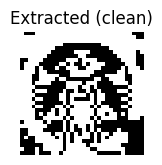

BER (jpeg q75): 0.201171875


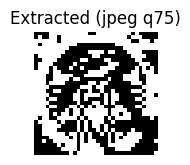

BER (small cutout): 0.1591796875


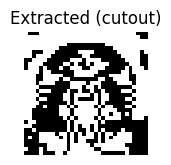

BER (rotation): 0.5966796875


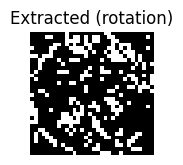

In [66]:
"""
Simple DWT+DCT+SVD+QIM Watermarking (NO TILING, NO RANDOM SEED, Blind, LL untouched)
------------------------------------------------------------------------------------

Design
- Work in Y (luma) channel only; keep original Cb/Cr untouched.
- 2-level DWT; embed ONLY in detail bands (H/V and optionally D). Never touch LL.
- For each (level, band):
    * 8×8 block DCT over the whole band (one big region; no tiling)
    * Use a 4×4 mid/low-mid patch inside each 8×8 block (rows/cols [1:5])
    * SVD that 4×4 patch; QIM-quantize ONE singular value (σ_k) to encode bits
- Deterministic, seedless mapping: round-robin across blocks (block k → bit k % n_bits)
- Repetition comes automatically when #blocks > #bits. Soft voting at extraction.

Notes
- Large QIM_STEP (e.g., 80–120) increases JPEG robustness but reduces image quality (PSNR).
- Keep host image size within 512–1080 px on BOTH height and width.
"""

import math
import cv2
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# =========================
# Adjustable hyperparameters
# =========================
DWT_LEVELS        = 2              # 2-level DWT
DCT_BLOCK_SIZE    = 8
QIM_STEP          = 80.0
WAVELET_NAME      = 'haar'
WAVELET_MODE      = 'symmetric'
WATERMARK_SIZE    = 32             # watermark is 32×32 binary

# =========================
# Small utilities
# =========================
def show_watermark(wm, title="Watermark", scale=4, threshold=None, save_path=None):
    """Display a single watermark (binarize if needed) with crisp pixels."""
    a = np.asarray(wm)
    thr = (0.5 if a.max() <= 1.0 else 127) if threshold is None else threshold
    a_bin = (a > thr).astype(np.uint8)
    a_disp = np.kron(a_bin, np.ones((max(1, int(scale)), max(1, int(scale))), dtype=np.uint8))
    plt.figure(figsize=(a_disp.shape[1]/80, a_disp.shape[0]/80))
    plt.imshow(a_disp, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
    plt.title(title); plt.axis("off")
    if save_path: plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def psnr(img_a_u8, img_b_u8):
    a = img_a_u8.astype(np.float64)
    b = img_b_u8.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    return 100.0 if mse <= 1e-12 else 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits_u8, pred_bits_u8):
    true_bits_u8 = np.asarray(true_bits_u8).astype(np.uint8).ravel()
    pred_bits_u8 = np.asarray(pred_bits_u8).astype(np.uint8).ravel()
    assert true_bits_u8.size == pred_bits_u8.size, "Mismatch in bit lengths."
    return np.count_nonzero(true_bits_u8 ^ pred_bits_u8) / true_bits_u8.size

def to_ycbcr_arrays(pil_rgb):
    """Return Y (float64), Cb (uint8), Cr (uint8)."""
    ycbcr = pil_rgb.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr

def from_ycbcr_arrays(Y_float, Cb_u8, Cr_u8):
    """Merge Y, Cb, Cr back to RGB (uint8)."""
    Y_u8 = np.rint(np.clip(Y_float, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y_u8),
                                  Image.fromarray(Cb_u8),
                                  Image.fromarray(Cr_u8)))
    return ycbcr.convert("RGB")

def prepare_watermark_bits(path, size=WATERMARK_SIZE):
    """Load any image → grayscale → Otsu → resize to size×size, return 0/1 bits."""
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.uint8)
    _, thr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = Image.fromarray(thr).resize((size, size), Image.NEAREST)
    bits = (np.array(thr, dtype=np.uint8) > 127).astype(np.uint8)
    return bits

# =========================
# DWT helpers (multi-level)
# =========================
def dwt2_levels(img_2d, levels=DWT_LEVELS):
    return pywt.wavedec2(img_2d, wavelet=WAVELET_NAME, level=levels, mode=WAVELET_MODE)

def idwt2_levels(coeffs):
    return pywt.waverec2(coeffs, wavelet=WAVELET_NAME, mode=WAVELET_MODE)

def get_detail_bands_all_levels(coeffs):
    """
    Return a list of (level_idx, band_tag, band_array_ref) for detail bands only.
    band_tag ∈ {'H','V'} (no diagonal band).
    """
    out = []
    levels = len(coeffs) - 1
    for l in range(levels, 0, -1):
        cH, cV, cD = coeffs[levels - l + 1]
        out.append((l, 'H', cH))
        out.append((l, 'V', cV))
    return out

def set_detail_band(coeffs, level_idx, band_tag, new_arr):
    """Write back a specific detail band at a given level."""
    levels = len(coeffs) - 1
    i = levels - level_idx + 1
    cH, cV, cD = coeffs[i]
    if band_tag == 'H':
        coeffs[i] = (new_arr, cV, cD)
    elif band_tag == 'V':
        coeffs[i] = (cH, new_arr, cD)

# =========================
# DCT (8×8 blockwise) helpers
# =========================
def dct_blocks_8x8(arr2d):
    """Blockwise 8×8 DCT with edge padding to multiples of 8."""
    H, W = arr2d.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(arr2d, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct_blocks_8x8(D, H, W):
    """Inverse blockwise 8×8 DCT; crop back to original size."""
    H8, W8 = D.shape
    out = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            out[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return out[:H, :W]

# =========================
# QIM primitives (scalar) on a single value
# =========================
def qim_embed_scalar(x, bit, step):
    """Quantize x into the center of the bit-labeled interval with step Δ=step."""
    q = np.floor(x / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_llr_scalar(x, step):
    """Soft-decision score: >0 means closer to bit=1; <0 closer to bit=0."""
    x /= step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# =========================
# SVD-on-block helpers (inside an 8×8 DCT block)
# =========================
def svd_qim_embed_in_block(D8, bit, step, svd_idx=0):
    """Embed bit into the singular value of an 8x8 DCT block using QIM."""
    U, S, Vt = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    S[k] = qim_embed_scalar(S[k], int(bit), step)
    D8[:] = (U * S) @ Vt  # U @ diag(S) @ Vt

def svd_qim_llr_from_block(D8, step, svd_idx=0):
    """Extract the soft-decision score for a given bit."""
    _, S, _ = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    return qim_llr_scalar(S[k], step)

# =========================
# Embedding (Y channel only) — NO TILING, NO RANDOM
# =========================
def embed_watermark_y(y_luma, wm_bits_2d):
    """
    Embed size×size binary watermark into Y using deterministic round-robin mapping.
    - Never touches LL subbands.
    - No randomness: block k carries bit (k % n_bits).
    """
    H0, W0 = y_luma.shape
    if not (512 <= H0 <= 1080 and 512 <= W0 <= 1080):
        raise ValueError("Host image must be within 512–1080 px on BOTH height and width.")

    # Pad so DWT levels and 8×8 DCT align cleanly
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    # DWT
    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    wm_bits = wm_bits_2d.astype(np.uint8).ravel()
    n_bits  = wm_bits.size

    for lvl, tag, band in detail_bands:
        # DCT over the entire band (single region)
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Deterministic round-robin mapping: block k → bit (k % n_bits)
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        # Embed per-block
        for k in range(n_blocks):
            bit_index = int(assign[k])
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            svd_qim_embed_in_block(
                D[i:i+8, j:j+8],
                int(wm_bits[bit_index]),
                QIM_STEP
            )

        # Write back the modified band
        band[:] = idct_blocks_8x8(D, Hb, Wb)
        set_detail_band(coeffs, lvl, tag, band)

    # Inverse DWT and crop back to original size
    y_wm_pad = idwt2_levels(coeffs)
    return y_wm_pad[:H0, :W0]

# =========================
# Extraction (blind) — NO TILING, NO RANDOM
# =========================
def extract_watermark_y(y_luma, wm_size=WATERMARK_SIZE, return_score=False):
    """
    Recreate the same deterministic round-robin mapping and do soft voting.
    """
    H0, W0 = y_luma.shape
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    n_bits = wm_size * wm_size
    soft_sum = np.zeros(n_bits, dtype=np.float64)

    for lvl, tag, band in detail_bands:
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Same round-robin mapping
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        for k in range(n_blocks):
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            llr = svd_qim_llr_from_block(
                D[i:i+8, j:j+8],
                QIM_STEP
            )
            soft_sum[int(assign[k])] += llr

    bits = (soft_sum >= 0).astype(np.uint8)

    # Reshape to 2D form for convenience in display (for rotation)
    if return_score:
        return bits.reshape(wm_size, wm_size), float(np.sum(np.abs(soft_sum)))
    
    return bits.reshape(wm_size, wm_size)

# =========================
# High-level convenience I/O
# =========================
def embed_watermark(host_path, wm_path, out_path="watermarked.png"):
    """Embed watermark image into host image file and save the watermarked RGB."""
    rgb = Image.open(host_path).convert("RGB")
    Y, Cb, Cr = to_ycbcr_arrays(rgb)
    wm_bits = prepare_watermark_bits(wm_path, WATERMARK_SIZE)
    Y_wm = embed_watermark_y(Y, wm_bits)
    out_rgb = from_ycbcr_arrays(Y_wm, Cb, Cr)
    out_rgb.save(out_path)
    return np.array(rgb, dtype=np.uint8), np.array(out_rgb, dtype=np.uint8), wm_bits

def extract_watermark(image_path, wm_size=WATERMARK_SIZE):
    """Extract watermark bits (wm_size×wm_size) from a watermarked/attacked image file."""
    rgb = Image.open(image_path).convert("RGB")
    Y, _, _ = to_ycbcr_arrays(rgb)
    wm_bits = extract_watermark_y(Y, wm_size)
    return wm_bits

def extract_watermark_with_rotation(img_path, wm_size=WATERMARK_SIZE,
                                    angle_range=(-5, 5), step=0.5):
    rgb = Image.open(img_path).convert("RGB")
    best_bits, best_score = None, -1.0
    for ang in np.arange(angle_range[0], angle_range[1]+1e-3, step):
        rot = rgb.rotate(ang, resample=Image.BICUBIC, expand=False)
        Y, _, _ = to_ycbcr_arrays(rot)
        bits, score = extract_watermark_y(Y, wm_size, return_score=True)
        if score > best_score:
            best_score, best_bits = score, bits
    return best_bits

# =========================
# (Optional) simple attack helpers for testing
# =========================
def attack_jpeg(in_path, out_path, quality=80):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_resize(in_path, out_path, scale=0.9):
    img = Image.open(in_path).convert("RGB")
    w, h = img.size
    img2 = img.resize((max(1, int(w*scale)), max(1, int(h*scale))), Image.LANCZOS)
    img3 = img2.resize((w, h), Image.LANCZOS)
    img3.save(out_path)

def attack_blur(in_path, out_path, k=3):
    arr = np.array(Image.open(in_path).convert("RGB"), dtype=np.uint8)
    k = k if k % 2 == 1 else k+1
    arrb = cv2.GaussianBlur(arr, (k, k), 0)
    Image.fromarray(arrb).save(out_path)

def attack_small_cutout(in_path, out_path,
                        area_ratio=0.008,     # ≈0.8% of full image area per patch
                        num_patches=2,
                        shape="rect",         # "rect" | "circle"
                        fill="noise",         # "noise" | "black" | "avg" | "blur" | "inpaint"
                        blur_kernel=11,
                        seed=None):
    """Tiny cutouts while keeping size; seed only for reproducibility of the ATTACK (not watermark)."""
    img = Image.open(in_path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    if fill == "blur":
        k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
        blurred = cv2.GaussianBlur(arr, (k, k), 0)

    def rect_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8); m[y0:y0+h, x0:x0+w] = 255; return m

    def circle_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2; r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]; m[(yy - cy)*2 + (xx - cx)*2 <= r*r] = 255; return m

    global_mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
    inpaint_accum_mask = np.zeros((H, W), dtype=np.uint8)

    for _ in range(max(1, int(num_patches))):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w))); y0 = int(rng.integers(0, max(1, H - h)))
        mask = rect_mask(x0, y0, w, h) if shape == "rect" else circle_mask(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            arr[mask == 255] = global_mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            inpaint_accum_mask = np.maximum(inpaint_accum_mask, mask)
        else:
            raise ValueError("fill must be one of: 'noise','black','avg','blur','inpaint'")

    if fill == "inpaint" and np.any(inpaint_accum_mask):
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        bgr = cv2.inpaint(bgr, inpaint_accum_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Image.fromarray(arr).save(out_path)

# =========================
# Example usage (uncomment to run locally)
# =========================
if __name__ == "__main__":
    host_path = "./images/image512.jpg"
    wm_path   = "./images/s.jpg"
    out_path  = "./images/watermarked.png"

    # Embed
    host_u8, watermarked_u8, wm_bits_true = embed_watermark(host_path, wm_path, out_path)
    print("PSNR host vs watermarked:", psnr(host_u8, watermarked_u8), "dB")

    # Extract from clean
    bits_clean = extract_watermark(out_path, WATERMARK_SIZE)
    print("BER (clean):", bit_error_rate(wm_bits_true, bits_clean))
    show_watermark(bits_clean, title="Extracted (clean)")

    # JPEG attack
    attack_jpeg(out_path, "./images/wm_jpeg75.jpg", quality=75)
    bits_jpeg = extract_watermark("./images/wm_jpeg75.jpg", WATERMARK_SIZE)
    print("BER (jpeg q75):", bit_error_rate(wm_bits_true, bits_jpeg))
    show_watermark(bits_jpeg, title="Extracted (jpeg q75)")

    # Small cutout attack
    attack_small_cutout(out_path, "./images/wm_cutout_black.png",
                        area_ratio=0.05, num_patches=1, shape="rect", fill="black", seed=42)
    bits_cut = extract_watermark("./images/wm_cutout_black.png", WATERMARK_SIZE)
    print("BER (small cutout):", bit_error_rate(wm_bits_true, bits_cut))
    show_watermark(bits_cut, title="Extracted (cutout)")

    # Small rotation attack
    # Create a rotated version of the watermarked image and save it
    rot_img = Image.open(out_path).convert("RGB").rotate(2, resample=Image.BICUBIC, expand=False)
    rot_img.save("./images/wm_rot.png")

    bits_rot = extract_watermark_with_rotation("./images/wm_rot.png", WATERMARK_SIZE)
    print("BER (rotation):", bit_error_rate(wm_bits_true, bits_rot))
    show_watermark(bits_rot, title="Extracted (rotation)")